# Assignment 5: Network Models and Statistical Analysis

In [89]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score
import random  # 确保导入random模块
from scipy import stats

from typing import Tuple, List, Dict, Union

## Part 1: Structural Properties of the Graph

In [75]:
def load_football_graph() -> nx.Graph:    
    G = nx.read_gml("football.gml")
    return G    

### 1.1

In [27]:
def calculate_graph_statistics(G: nx.Graph) -> Dict[str, Union[float, List[int]]]:
    """
    计算图的各种统计特性
    
    Inputs:
    G: NetworkX graph object
    
    Returns:
    Dictionary of graph statistics
    """
    # 确保使用最大连通分量进行计算
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len))
    
    # 计算直径
    diameter = nx.diameter(G)
    
    # 计算特征路径长度
    cpl = nx.average_shortest_path_length(G)
    
    # 计算平均聚类系数
    avg_clustering = nx.average_clustering(G)
    
    # 计算传递性
    transitivity = nx.transitivity(G)
    
    # 计算同配性
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # 获取度序列
    degree_sequence = [d for n, d in G.degree()]
    
    # 创建并返回包含所有统计信息的字典
    graph_statistics = {
        'diameter': diameter,
        'cpl': cpl,
        'avg_clustering': avg_clustering,
        'transitivity': transitivity,
        'assortativity': assortativity,
        'degree_sequence': degree_sequence
    }
    
    return graph_statistics

### 1.2

In [30]:
def sweep_louvain_resolutions(G: nx.Graph, min_resolution: int=1, max_resolution: int=10) -> Tuple[List[int], List[float]]:
    """
    在不同分辨率参数下使用Louvain算法进行社区检测，并计算NMI
    
    Inputs:
    G: NetworkX graph object
    min_resolution : integer
    max_resolution : integer
    
    Returns:
    Tuple of list of resolutions and list of NMIs
    """
    # 获取真实社区标签
    true_communities = {}
    for node in G.nodes():
        community = G.nodes[node]['value']
        if community not in true_communities:
            true_communities[community] = []
        true_communities[community].append(node)
    
    # 转换为列表形式
    true_partition = list(true_communities.values())
    
    # 创建真实标签的映射
    true_labels = {}
    for i, comm in enumerate(true_partition):
        for node in comm:
            true_labels[node] = i
    
    # 存储不同分辨率的值和对应的NMI
    resolutions = list(range(min_resolution, max_resolution + 1))
    nmis = []
    
    # 对每个分辨率运行Louvain算法
    for resolution in resolutions:
        # 使用Louvain算法找到社区
        communities = louvain_communities(G, resolution=resolution)
        
        # 创建预测标签的映射
        pred_labels = {}
        for i, comm in enumerate(communities):
            for node in comm:
                pred_labels[node] = i
        
        # 提取标签列表，保持顺序一致
        nodes = list(G.nodes())
        true_label_list = [true_labels[node] for node in nodes]
        pred_label_list = [pred_labels[node] for node in nodes]
        
        # 计算NMI
        nmi = normalized_mutual_info_score(true_label_list, pred_label_list)
        nmis.append(nmi)
    
    return resolutions, nmis


def plot_nmi_vs_resolution(resolutions: List[int], nmis: List[float], save: bool=False) -> None:
    """
    绘制NMI随分辨率变化的曲线图
    
    Inputs:
    resolutions : 分辨率参数列表
    nmis : 对应的NMI值列表
    save: boolean
    
    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(resolutions, nmis, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Resolution Parameter')
    plt.ylabel('Normalized Mutual Information (NMI)')
    plt.title('NMI vs Resolution for Louvain Community Detection')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(resolutions)
    
    # 找到最佳分辨率
    best_idx = np.argmax(nmis)
    best_resolution = resolutions[best_idx]
    best_nmi = nmis[best_idx]
    
    plt.scatter([best_resolution], [best_nmi], color='red', s=100, zorder=5, 
                label=f'Best Resolution = {best_resolution}, NMI = {best_nmi:.4f}')
    plt.legend()
    
    if save:
        plt.savefig('1_2_1.png')

    plt.tight_layout()
    plt.show()

### 1.3

In [33]:
def calculate_best_partition(G: nx.Graph, resolutions: List[int], nmis: List[float]) -> Tuple[int, List[set[str]]]:
    """
    找到产生最高NMI的分辨率及其对应的社区划分
    
    Inputs:
    G: NetworkX graph object
    resolutions : a list of integer
    nmis :a list of float
    
    Returns:
    Tuple of resolution and partition
    """
    # 找到最高NMI的索引
    best_idx = np.argmax(nmis)
    best_resolution = resolutions[best_idx]
    
    # 使用最佳分辨率重新计算社区
    partition = louvain_communities(G, resolution=best_resolution)
    
    return best_resolution, partition

def plot_best_partition(G: nx.Graph, partition: List[set], save: bool=False) -> None:
    """
    可视化网络中的真实社区和最优社区划分
    
    Inputs:
    G: NetworkX graph object
    partition : List[set]
    save: boolean
    
    Returns:
    None
    """
    # 创建图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # 获取真实社区
    true_communities = {}
    for node in G.nodes():
        community = G.nodes[node]['value']
        if community not in true_communities:
            true_communities[community] = []
        true_communities[community].append(node)
    
    true_partition = list(true_communities.values())
    
    # 为真实社区分配颜色
    true_colors = {}
    for i, comm in enumerate(true_partition):
        for node in comm:
            true_colors[node] = i
    
    # 为Louvain社区分配颜色
    louvain_colors = {}
    for i, comm in enumerate(partition):
        for node in comm:
            louvain_colors[node] = i
    
    # 绘制真实社区
    pos = nx.spring_layout(G, seed=42)  # 使用相同的布局
    
    # 左边绘制真实社区
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=list(true_colors.values()), 
                        cmap=plt.cm.tab20, node_size=100)
    nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.5)
    ax1.set_title('Ground Truth Communities')
    ax1.axis('off')
    
    # 右边绘制Louvain社区
    nx.draw_networkx_nodes(G, pos, ax=ax2, node_color=list(louvain_colors.values()), 
                        cmap=plt.cm.tab20, node_size=100)
    nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.5)
    ax2.set_title('Louvain Communities (Best Resolution)')
    ax2.axis('off')
    
    if save:
        plt.savefig('1_2_2.png')

    plt.tight_layout()
    plt.show()


### 1.4

In [36]:
def calculate_inter_community_density(G: nx.Graph, partition: list) -> Tuple[np.ndarray, List[int]]:
    """
    计算社区间连接密度矩阵
    
    Inputs:
    G: NetworkX graph object
    partition : list
    
    Returns:
    Tuple of np array and List[int], intercommunity connection density matrix
    """
    num_communities = len(partition)
    p = np.zeros((num_communities, num_communities))
    sizes = [len(community) for community in partition]
    
    # 为节点分配社区索引
    node_to_community = {}
    for i, community in enumerate(partition):
        for node in community:
            node_to_community[node] = i
    
    # 计算社区间连接密度
    for u, v in G.edges():
        comm_u = node_to_community[u]
        comm_v = node_to_community[v]
        
        # 对自环进行特殊处理
        if u == v:
            continue
            
        # 计算社区之间的连接
        if comm_u == comm_v:
            # 社区内连接
            size = sizes[comm_u]
            # 社区内最大可能边数 = n*(n-1)/2
            max_edges = size * (size - 1) / 2
            if max_edges > 0:
                p[comm_u, comm_v] += 1 / max_edges
        else:
            # 社区间连接
            # 两个社区之间最大可能边数 = n1*n2
            max_edges = sizes[comm_u] * sizes[comm_v]
            p[comm_u, comm_v] += 1 / max_edges
    
    return p, sizes

def plot_p_matrix(p: np.ndarray, save: bool=False):
    """
    可视化社区间连接密度矩阵
    
    Inputs:
    p: np array, intercommunity connection density matrix
    save: boolean
    
    Returns:
    None
    """
    plt.figure(figsize=(12, 10))
    
    # 使用热图显示矩阵
    im = plt.imshow(p, cmap='YlOrRd')
    
    # 添加颜色条
    cbar = plt.colorbar(im)
    cbar.set_label('Connection Density')
    
    # 设置坐标轴标签
    plt.xlabel('Community Index')
    plt.ylabel('Community Index')
    plt.title('Inter-community Connection Density Matrix')
    
    # 添加网格线
    plt.grid(False)
    
    # 在每个单元格中显示值
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            text_color = 'black' if p[i, j] < 0.5 else 'white'
            plt.text(j, i, f'{p[i, j]:.3f}', ha='center', va='center', color=text_color)
    
    if save:
        plt.savefig('1_3.png')

    plt.tight_layout()
    plt.show()

### 1.5

Run the code in the 1.5 cell. How does the resolution impact the NMI? Is the partition for the best NMI a good match to the ground truth? Justify your answer based on the visual plot and the NMI value itself.

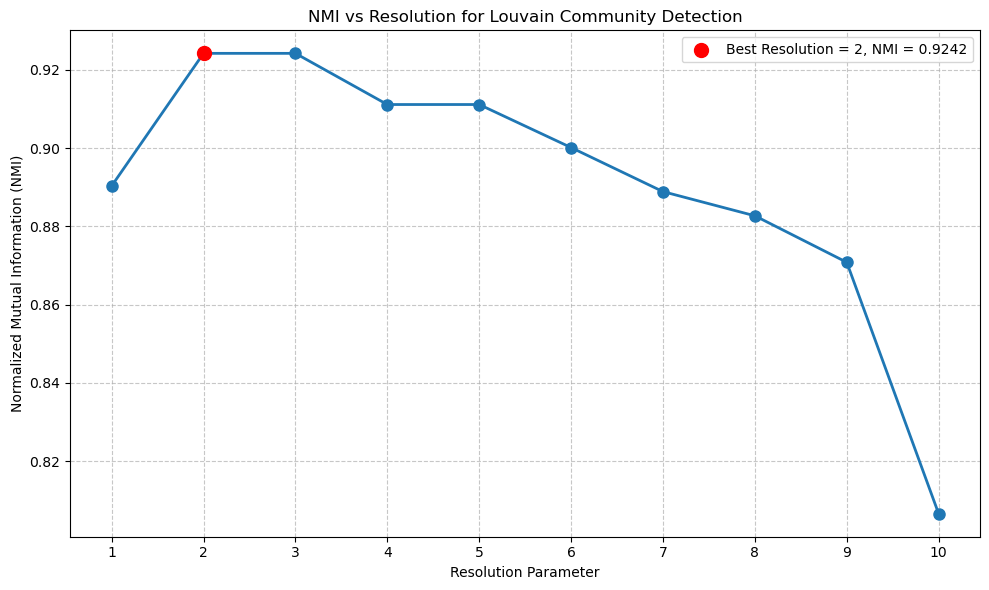

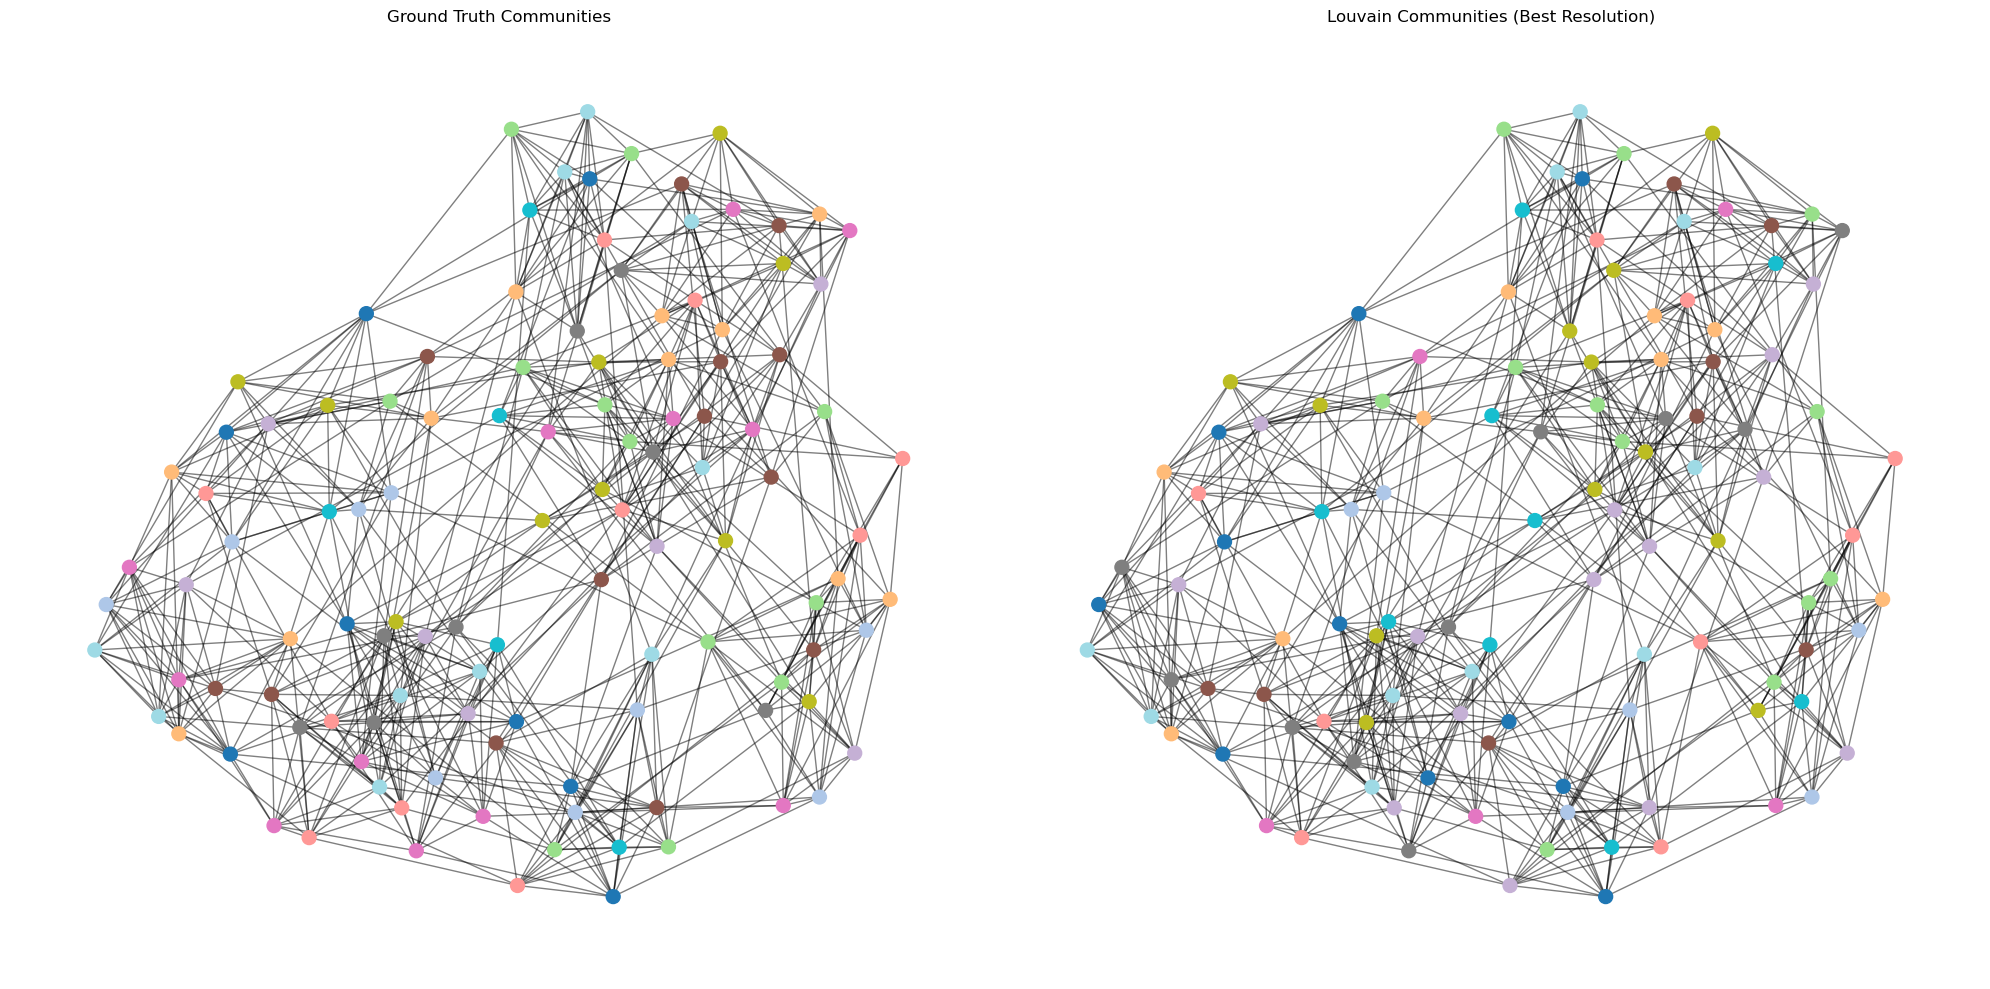

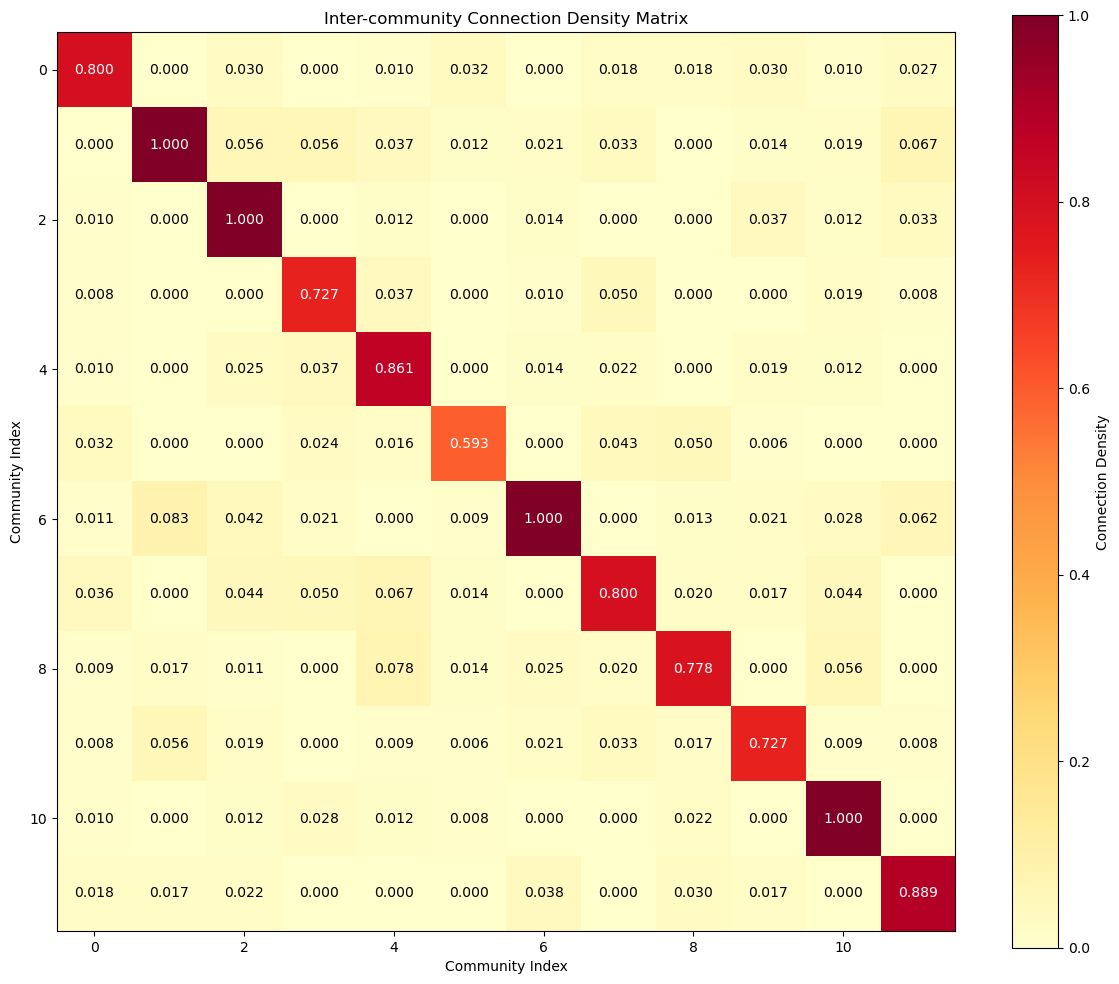

In [40]:
"""
1.5 cell
"""
G = load_football_graph()

# 1.1
graph_stats = calculate_graph_statistics(G)

# 1.2 
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
plot_nmi_vs_resolution(resolutions, nmis)
plot_best_partition(G, partition)

# 1.3
p, sizes = calculate_inter_community_density(G, partition)
plot_p_matrix(p)


### 1.5 Written Response

Answer:

## Part 2: Graph Generators
### 2.1

In [91]:
def generate_configuration_graphs(degree_sequence: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    使用配置模型生成具有相同度分布的随机图
    
    Inputs:
    degree_sequence: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """
    graphs = []
    
    for _ in range(n_graphs):
        # 使用NetworkX的配置模型生成图
        G = nx.configuration_model(degree_sequence, create_using=nx.Graph())
        
        # 移除自环和多重边，确保生成简单图
        G.remove_edges_from(nx.selfloop_edges(G))
        
        # 确保图是连通的
        if not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        
        graphs.append(G)
    
    return graphs

def generate_sbm_graphs(p: np.ndarray, sizes: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    使用随机块模型生成具有社区结构的随机图
    
    Inputs:
    p: np.ndarray, element (r,s) gives the density of edges going from the nodes of group r to nodes of group s.
    sizes: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """
    # 确保概率矩阵是对称的
    p_symmetric = np.zeros_like(p)
    for i in range(len(p)):
        for j in range(len(p)):
            p_symmetric[i][j] = (p[i][j] + p[j][i]) / 2
    
    # 检查对称性
    if not np.allclose(p_symmetric, p_symmetric.T, rtol=1e-10, atol=1e-10):
        raise ValueError("Failed to create a symmetric probability matrix")
    
    graphs = []
    
    for _ in range(n_graphs):
        try:
            # 使用随机块模型生成图
            G = nx.stochastic_block_model(sizes, p_symmetric)
            
            # 确保图是连通的
            if not nx.is_connected(G):
                G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
            
            graphs.append(G)
        except Exception as e:
            print(f"Error generating SBM graph: {e}")
            # 在出错时添加一个默认图作为替代
            G = nx.erdos_renyi_graph(sum(sizes), 0.5)
            if not nx.is_connected(G):
                G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
            graphs.append(G)
    
    return graphs

### 2.2

In [94]:
def calculate_edge_probability(dendrogram: nx.DiGraph) -> Dict[str, Dict[str, float]]:
    """
    计算所有叶节点对之间的边概率
    
    Inputs:
    dendrogram: NetworkX graph object    
    
    Returns:
    a dictionary of edge probabilities between all pairs of leaf nodes.
    """
    # 获取叶节点（没有出边的节点）
    leaf_nodes = [node for node in dendrogram.nodes() if dendrogram.out_degree(node) == 0]
    
    # 初始化边概率字典
    edge_probs = {node: {} for node in leaf_nodes}
    
    # 对于每对叶节点，计算它们之间的连接概率
    for i, node1 in enumerate(leaf_nodes):
        for node2 in leaf_nodes[i:]:  # 只需要计算一半的矩阵（包括对角线）
            if node1 == node2:
                # 自己与自己不连接
                edge_probs[node1][node2] = 0
                continue
            
            # 找到两个节点的最近公共祖先
            prob = find_edge_probability(dendrogram, node1, node2)
            
            # 由于是无向图，所以概率是对称的
            edge_probs[node1][node2] = prob
            edge_probs[node2][node1] = prob
    
    return edge_probs

def find_edge_probability(dendrogram: nx.DiGraph, node1: str, node2: str) -> float:
    """
    找到两个叶节点之间的连接概率
    
    Inputs:
    dendrogram: NetworkX graph object
    node1: 第一个叶节点
    node2: 第二个叶节点
    
    Returns:
    float: 连接概率
    """
    # 找到从根到两个叶节点的路径
    root = [node for node in dendrogram.nodes() if dendrogram.in_degree(node) == 0][0]
    
    path1 = find_path(dendrogram, root, node1)
    path2 = find_path(dendrogram, root, node2)
    
    # 找到最近公共祖先
    lca = None
    for n1, n2 in zip(path1, path2):
        if n1 == n2:
            lca = n1
        else:
            break
    
    # 如果没有找到公共祖先，则返回0
    if lca is None:
        return 0
    
    # 返回LCA节点的p属性，如果存在的话
    if 'p' in dendrogram.nodes[lca]:
        return float(dendrogram.nodes[lca]['p'])
    else:
        # 如果没有p属性，可能是根节点，返回默认值或计算
        children = list(dendrogram.successors(lca))
        if len(children) == 2:
            left, right = children
            # 检查node1和node2是否分别在左右子树中
            in_left1 = is_descendant(dendrogram, left, node1)
            in_left2 = is_descendant(dendrogram, left, node2)
            
            if (in_left1 and not in_left2) or (not in_left1 and in_left2):
                # 一个在左子树，一个在右子树
                if 'p' in dendrogram.nodes[lca]:
                    return float(dendrogram.nodes[lca]['p'])
        
        # 默认值，实际中应该根据HRG模型的具体实现调整
        return 0.5

def find_path(graph: nx.DiGraph, start: str, end: str) -> List[str]:
    """
    在有向图中找到从start到end的路径
    """
    if start == end:
        return [start]
    
    for neighbor in graph.successors(start):
        if is_descendant(graph, neighbor, end):
            return [start] + find_path(graph, neighbor, end)
    
    return []

def is_descendant(graph: nx.DiGraph, ancestor: str, descendant: str) -> bool:
    """
    检查descendant是否是ancestor的后代
    """
    if ancestor == descendant:
        return True
    
    if graph.out_degree(ancestor) == 0:
        return False
    
    for child in graph.successors(ancestor):
        if is_descendant(graph, child, descendant):
            return True
    
    return False

def generate_graph_from_prob(edge_probs: Dict[str, Dict[str, float]]) -> nx.Graph:
    """
    根据边概率生成图
    
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    
    Returns:
    H: NetworkX graph object
    """
    # 创建空图
    H = nx.Graph()
    
    # 添加所有节点
    H.add_nodes_from(edge_probs.keys())
    
    # 根据概率添加边
    for node1 in edge_probs:
        for node2, prob in edge_probs[node1].items():
            # 避免重复添加边（因为edge_probs是对称的）
            if node1 < node2:  # 按字典序只处理一次
                # 根据概率决定是否添加边
                if random.random() < prob:
                    H.add_edge(node1, node2)
    
    return H

def generate_hrg_graphs(edge_probs: Dict[str, Dict[str, float]], n_graphs: int=100) -> List[nx.Graph]:
    """
    生成多个HRG图
    
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    n_graphs: int
    
    Returns:
    a list of NetworkX graph object
    """
    graphs = []
    
    for _ in range(n_graphs):
        # 使用边概率生成一个图
        G = generate_graph_from_prob(edge_probs)
        
        # 确保图是连通的
        if not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        
        graphs.append(G)
    
    return graphs

### 2.3

In [97]:
def calculate_generated_statistics(graphs: List[nx.Graph]) -> Dict[str, list]:
    """
    计算生成图的统计特性
    
    Inputs:
    graphs: a list of NetworkX graph object
    
    Returns:
    a dictionary of graph statistics
    """
    # 初始化统计数据字典
    graph_statistics = {
        'diameter': [],
        'cpl': [],
        'avg_clustering': [],
        'transitivity': [],
        'assortativity': []
    }
    
    # 对每个图计算统计特性
    for G in graphs:
        # 确保使用最大连通分量进行计算
        if not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len))
        
        # 计算直径
        graph_statistics['diameter'].append(nx.diameter(G))
        
        # 计算特征路径长度
        graph_statistics['cpl'].append(nx.average_shortest_path_length(G))
        
        # 计算平均聚类系数
        graph_statistics['avg_clustering'].append(nx.average_clustering(G))
        
        # 计算传递性
        graph_statistics['transitivity'].append(nx.transitivity(G))
        
        # 计算同配性
        graph_statistics['assortativity'].append(nx.degree_assortativity_coefficient(G))
    
    return graph_statistics

def compare_generated_to_ground_truth(ground_truth_features: Dict[str, float], generated_features: Dict[str, List[float]]) -> Dict[str, float]:
    """
    使用单样本t检验比较生成图与真实图的统计特性
    
    Inputs:
    ground_truth_features: a dictionary of graph statistics
    generated_features: a dictionary of graph statistics
    
    Returns:
    a dictionary of one-sample t-test
    """
    p_vals = {}
    
    # 对每个特性进行t检验
    for feature in ['diameter', 'cpl', 'avg_clustering', 'transitivity', 'assortativity']:
        # 提取地面真实值和生成值
        true_value = ground_truth_features[feature]
        gen_values = generated_features[feature]
        
        # 执行单样本t检验
        t_stat, p_value = stats.ttest_1samp(gen_values, true_value)
        
        # 存储p值
        p_vals[feature] = p_value
    
    return p_vals

def plot_graph_statistics(graph_statistics: List[Dict[str, list]], save: bool=False) -> None:
    """
    可视化不同生成器的图统计特性
    
    Inputs:
    graph_statistics: a list of dictionaries of graph statistics
    save: boolean
    
    Returns:
    None
    """
    # 提取数据
    ground_truth = graph_statistics[0]
    config_stats = graph_statistics[1]
    sbm_stats = graph_statistics[2]
    hrg_stats = graph_statistics[3]
    
    # 要比较的特性
    features = ['diameter', 'cpl', 'avg_clustering', 'transitivity', 'assortativity']
    
    # 创建子图
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    
    # 模型名称
    model_names = ['Config', 'SBM', 'HRG']
    
    # 为每个特性创建箱线图
    for i, feature in enumerate(features):
        # 提取数据
        config_data = config_stats[feature]
        sbm_data = sbm_stats[feature]
        hrg_data = hrg_stats[feature]
        
        # 组织数据用于箱线图
        data = [config_data, sbm_data, hrg_data]
        
        # 绘制箱线图
        axes[i].boxplot(data, labels=model_names)
        
        # 添加真实值为水平线
        axes[i].axhline(y=ground_truth[feature], color='r', linestyle='-', label='Ground Truth')
        
        # 设置标题和标签
        axes[i].set_title(feature.capitalize())
        axes[i].set_ylabel('Value')
        
        # 添加图例
        if i == 0:
            axes[i].legend()
    
    plt.tight_layout()
    
    if save:
        plt.savefig('2_3.png')
    
    plt.show()


### 2.4
This code reruns some calculations from 1.5 to avoid errors, but you can comment it out if you already have the values stored in memory.

Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Entries of 'p' not in [0,1].
Error generating SBM graph: Ent

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/j5/112p20755vs10yhtx9rccbb40000gn/T/ipykernel_58160/3880670720.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=model_names)
/var/folders/j5/112p20755vs10yhtx9rccbb40000gn/T/ipykernel_58160/3880670720.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=model_names)
/var/folders/j5/112p20755vs10yhtx9rccbb40000gn/T/ipykernel_58160/3880670720.py:107: MatplotlibDeprecationWarnin

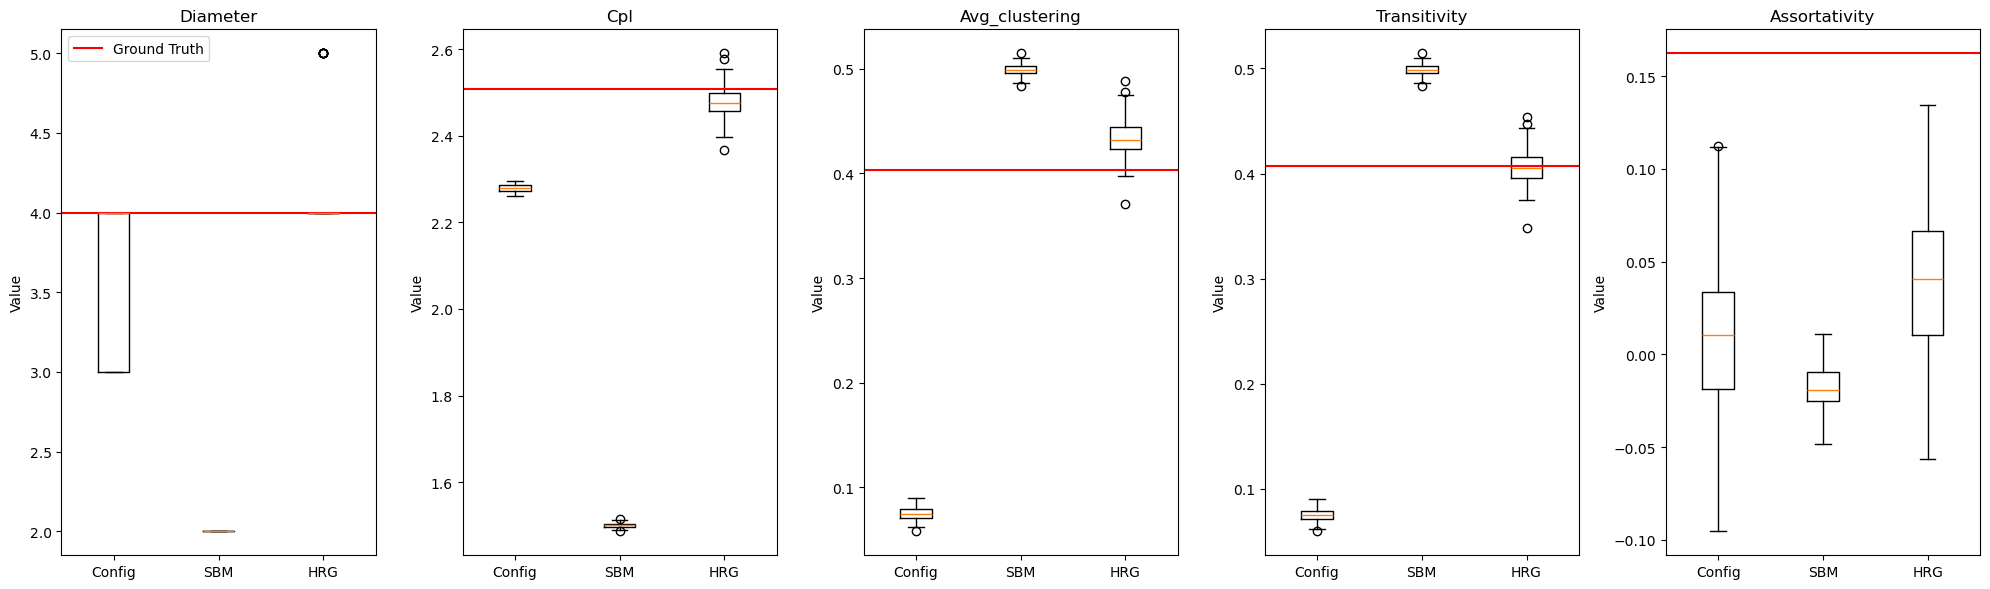

In [100]:
G = load_football_graph()
graph_stats = calculate_graph_statistics(G)

# Configuration Model
config_graphs = generate_configuration_graphs(graph_stats['degree_sequence'])

# Stochastic Block Model
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
p, sizes = calculate_inter_community_density(G, partition)
sbm_graphs = generate_sbm_graphs(p, sizes)

# Hierarchical Random Graph Model
dendrogram = nx.read_gml("football-hrg.gml")
edge_probs = calculate_edge_probability(dendrogram)
hrg_graphs = generate_hrg_graphs(edge_probs)

# Calculating network characteristic statistics
config_stats = calculate_generated_statistics(config_graphs)
sbm_stats = calculate_generated_statistics(sbm_graphs)
hrg_stats = calculate_generated_statistics(hrg_graphs)

# Hypothesis Test Stats
print('Configuration Model t-test')
print(compare_generated_to_ground_truth(graph_stats, config_stats))

print('Stochastic Block Model t-test')
print(compare_generated_to_ground_truth(graph_stats, sbm_stats))

print('HRG Model t-test')
print(compare_generated_to_ground_truth(graph_stats, hrg_stats))

plot_graph_statistics([graph_stats, config_stats, sbm_stats, hrg_stats])

### 2.4 Written Response

Answer: 

## Part 3: Slashdot Network

In [107]:
def load_slashdot_graph() -> nx.Graph:
    # import "slashdot.txt"
    G = nx.read_edgelist("slashdot.txt", delimiter="\t", create_using=nx.DiGraph)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

### 3.1

In [123]:
def estimate_network_size(G, sample_sizes: List[int]=[500, 1000, 2000, 5000, 10000], n_iter: int=1000) -> Dict[str, List[int]]:
    """
    使用捕获-再捕获方法估计网络大小
    
    Inputs:
    G: NetworkX graph object
    sample_sizes: List[int]
    n_iter: int

    Returns:
    a dictionary where key is the sample size and the value is a list of the estimated network sizes for each trial
    """
    import random  # 在函数内部导入，确保可用
    
    # 获取所有节点
    all_nodes = list(G.nodes())
    total_nodes = len(all_nodes)
    
    # 初始化结果字典 - 使用整数作为键
    results = {size: [] for size in sample_sizes}
    
    # 对每个样本大小进行多次实验
    for size in sample_sizes:
        for _ in range(n_iter):
            # 第一次采样（n1）
            sample1 = random.sample(all_nodes, size)
            
            # 第二次采样（n2）
            sample2 = random.sample(all_nodes, size)
            
            # 统计重复节点数（n3）
            n3 = len(set(sample1) & set(sample2))
            
            # 避免除以零
            if n3 == 0:
                continue
            
            # 使用捕获-再捕获公式估计总节点数
            estimated_size = len(sample1) * len(sample2) // n3
            
            # 存储结果
            results[size].append(estimated_size)
    
    return results

def plot_estimate_histogram(estimated_sizes: List[int], true_size: int, save: bool=False) -> None:
    """
    绘制估计节点数的直方图
    
    Inputs:
    estimated_sizes: List[int]
    true_size: int
    save:boolean

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    
    # 计算直方图的范围
    min_val = min(estimated_sizes)
    max_val = max(estimated_sizes)
    
    # 绘制直方图
    plt.hist(estimated_sizes, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    
    # 添加真实大小的垂直线
    plt.axvline(x=true_size, color='red', linestyle='--', linewidth=2, 
                label=f'True Size: {true_size}')
    
    # 添加标题和标签
    plt.title('Histogram of Estimated Network Sizes')
    plt.xlabel('Estimated Number of Nodes')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 添加网格线
    plt.grid(alpha=0.3)
    
    if save:
        plt.savefig('3_1_1.png')

    plt.tight_layout()
    plt.show()

def plot_sample_size_error(results: Dict[int, List[int]], true_size: int,
                           sample_sizes: List[int]=[500, 1000, 2000, 5000, 10000], save: bool=False) -> None:
    """
    绘制不同样本大小下的估计值及其误差
    
    Inputs:
    results: Dict[int, List[int]]  # 现在键是整数
    true_size: int
    sample_sizes: List[int]
    save:boolean

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    
    # 计算每个样本大小的平均值和标准差
    means = []
    stds = []
    
    for size in sample_sizes:
        estimates = results[size]  # 现在直接使用整数键
        means.append(np.mean(estimates))
        stds.append(np.std(estimates))
    
    # 绘制误差线图
    plt.errorbar(sample_sizes, means, yerr=stds, fmt='o-', capsize=5, 
                linewidth=2, markersize=8, label='Estimated Size with Std Dev')
    
    # 添加真实大小的水平线
    plt.axhline(y=true_size, color='red', linestyle='--', linewidth=2, 
                label=f'True Size: {true_size}')
    
    # 添加标题和标签
    plt.title('Estimated Network Size vs Sample Size')
    plt.xlabel('Sample Size')
    plt.ylabel('Estimated Number of Nodes')
    plt.legend()
    
    # 设置x轴为样本大小
    plt.xticks(sample_sizes)
    
    # 添加网格线
    plt.grid(alpha=0.3)
    
    if save:
         plt.savefig('3_1_2.png')

    plt.tight_layout()
    plt.show()

### 3.2

In [126]:
def estimate_edges(G: nx.Graph, n_sample: int=5000, n_iter: int=100) -> List[int]:
    """
    使用诱导子图采样和Horvitz-Thompson估计器估计边数
    
    Inputs:
    G: NetworkX graph object
    n_sample: int
    n_iter: int

    Returns:
    a list of estimated_edges
    """
    import random  # 在函数内部导入，确保可用
    
    # 获取所有节点和边
    all_nodes = list(G.nodes())
    total_nodes = len(all_nodes)
    
    # 初始化估计结果列表
    estimated_edges = []
    
    # 进行多次实验
    for _ in range(n_iter):
        # 随机抽样节点
        sampled_nodes = random.sample(all_nodes, n_sample)
        
        # 创建诱导子图
        subgraph = G.subgraph(sampled_nodes)
        
        # 统计子图中的边数
        subgraph_edges = len(subgraph.edges())
        
        # 使用Horvitz-Thompson估计器估计总边数
        # 每条边被采样的概率 = (n_sample/total_nodes)^2
        p_edge = (n_sample / total_nodes) ** 2
        estimated_edge_count = subgraph_edges / p_edge
        
        # 存储结果
        estimated_edges.append(int(estimated_edge_count))
    
    return estimated_edges

def plot_edge_estimate_distribution(estimated_edges: List[int], true_edges: int, save: bool=False) -> None:
    """
    绘制估计边数的分布直方图
    
    Inputs:
    estimated_edges: List[int]
    true_edges: int
    save: boolean

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    
    # 计算直方图的范围
    min_val = min(estimated_edges)
    max_val = max(estimated_edges)
    
    # 绘制直方图
    plt.hist(estimated_edges, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    
    # 添加真实大小的垂直线
    plt.axvline(x=true_edges, color='red', linestyle='--', linewidth=2, 
                label=f'True Edges: {true_edges}')
    
    # 计算估计的平均值和标准差
    mean_estimate = np.mean(estimated_edges)
    std_estimate = np.std(estimated_edges)
    
    # 添加估计平均值的垂直线
    plt.axvline(x=mean_estimate, color='green', linestyle='-', linewidth=2,
                label=f'Mean Estimate: {mean_estimate:.0f} ± {std_estimate:.0f}')
    
    # 添加标题和标签
    plt.title('Distribution of Edge Count Estimates')
    plt.xlabel('Estimated Number of Edges')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 添加网格线
    plt.grid(alpha=0.3)
    
    if save:
        plt.savefig('3_2.png')

    plt.tight_layout()
    plt.show()

### 3.3

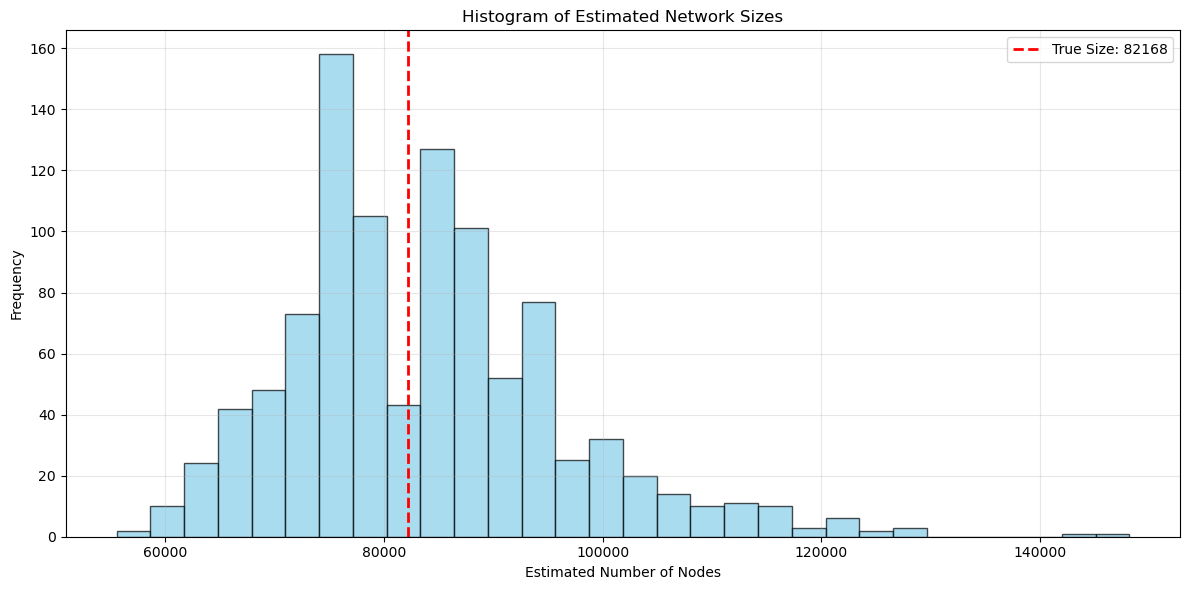

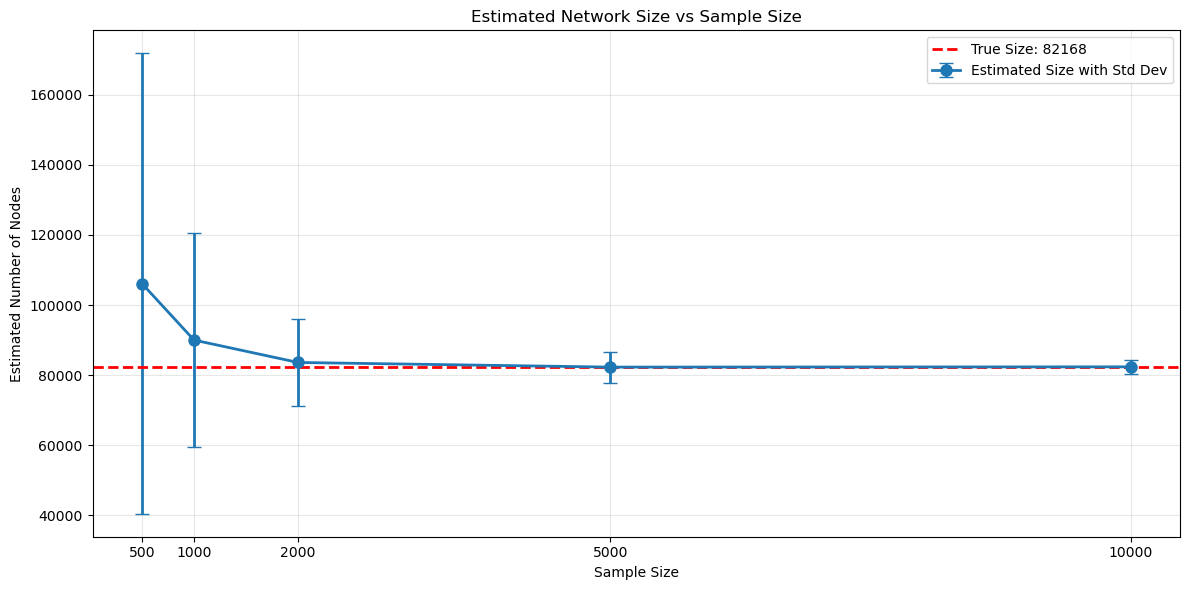

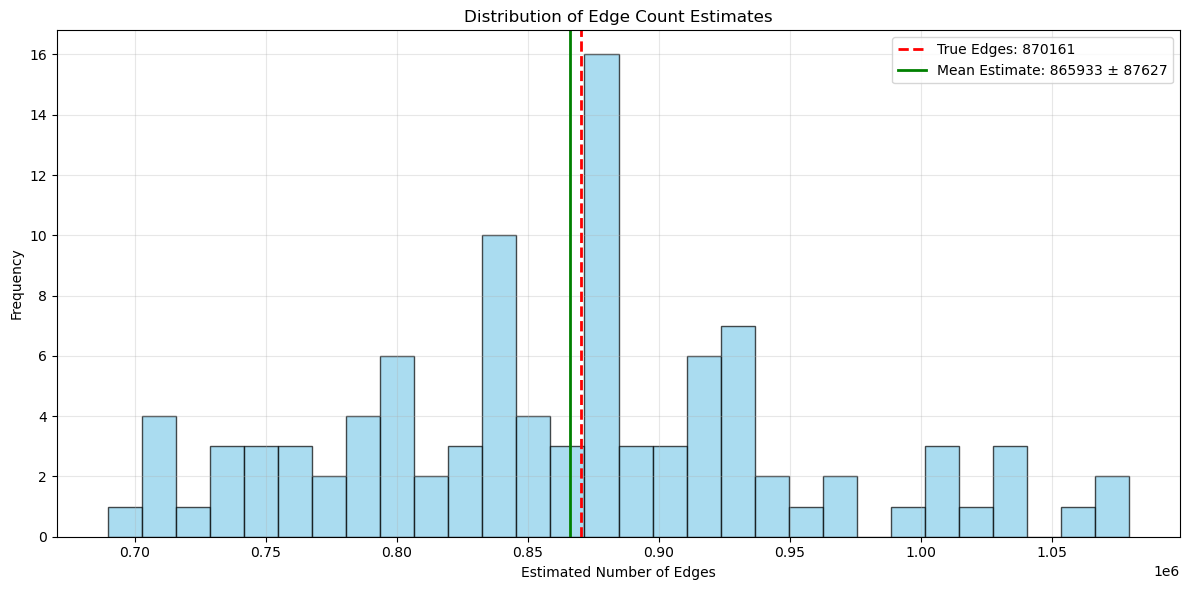

In [129]:
G = load_slashdot_graph()

network_size_estimates = estimate_network_size(G)

plot_estimate_histogram(network_size_estimates[2000], len(G.nodes()))
plot_sample_size_error(network_size_estimates, len(G.nodes()))

edge_estimates = estimate_edges(G)
plot_edge_estimate_distribution(edge_estimates, len(G.edges()))



### 3.3 Written Response

Answer: